In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

train_data = pd.read_csv('train_update.csv')
test_data = pd.read_csv('test_update.csv')

train_data = train_data.drop('origin',axis = 1)
test_data = test_data.drop(['item_1','item_2','item_3','item_4','item_5','item_6',
                          'item_7','item_8','item_9','item_10','item_11','item_12',
                          'item_13','item_14','item_15','item_16','item_17','item_18',
                          'item_19','item_20','item_21','item_22','item_23','item_24','origin'],axis =1)
train_data['item_22'] = train_data['item_22'].replace(np.nan, 0)
train_data['item_23'] = train_data['item_23'].replace(np.nan, 0)

train_data = train_data.sort_values(by=['user_id','date'],ascending=[True, False])
train_data = train_data.reset_index(drop = True)

train_data_test1 = train_data[['user_id','date','item_1','item_2','item_3',
                              'item_4','item_5','item_6','item_7','item_8',
                              'item_9','item_10','item_11','item_12','item_13',
                              'item_14','item_15','item_16','item_17','item_18',
                              'item_19','item_20','item_21','item_22','item_23','item_24']]

user_id_list = list(set(train_data_test1['user_id']))
user_id_list.sort()

col_name = list()
for num1 in range(1,25):
    col_name.append('item'+str(num1)+'_buy')

#对产品列进行处理，用户第一次出现的那行产品信息不变，后续日期行进行差分，差分结果为1表示用户在这个日期新购买了该产品，
#-1表示用户在这个日期卖出了该产品，0表示用户未对产品进行操作，将差分结果作为训练的目标标签
train_data_all = pd.DataFrame(columns = col_name)
for user_id_num in tqdm(user_id_list):
    train_data_one = train_data_test1[train_data_test1.user_id == user_id_num]
    train_data_one_temp = train_data_one.drop(['user_id','date'],axis=1)
    train_data_one_matrix = train_data_one_temp.values
    row_num = len(train_data_one_matrix)
    if row_num == 1:
        train_data_one_matrix = train_data_one_matrix
    else:
        for i in range(row_num-1): 
            train_data_one_matrix[i] = train_data_one_matrix[i+1]*(-1)+train_data_one_matrix[i]
    train_data_one_new = pd.DataFrame(train_data_one_matrix,columns=col_name)
    train_data_all = pd.concat([train_data_all, train_data_one_new],ignore_index = True)

100%|████████████████████████████████████████████████████████████████████████████| 39697/39697 [20:32<00:00, 32.21it/s]


In [2]:
train_data1 = pd.concat([train_data,train_data_all] ,axis =1)

train_data1 = train_data1.drop(['item_1','item_2','item_3',
                              'item_4','item_5','item_6','item_7','item_8',
                              'item_9','item_10','item_11','item_12','item_13',
                              'item_14','item_15','item_16','item_17','item_18',
                              'item_19','item_20','item_21','item_22','item_23','item_24'],axis =1)

train_data1.to_csv('train_data1.csv',index = 0)

In [3]:
#去除日期标签，新增月标记，因为用户的产品购买存在一定的月份特征
train_data1['date']=pd.to_datetime(train_data1['date'],format='%Y-%m-%d')
train_data1['month_label'] = train_data1['date'].map(lambda x: x.month)

for num in col_name:
    train_data1[num] = train_data1[num].map(lambda x: 0 if x<0 else x)

train_data1['use_time'] = train_data1['use_time'].map(lambda x: 0 if x<0 else x)
train_data1 = train_data1.drop('date',axis =1)
test_data = test_data.drop('date',axis = 1)
test_data['month_label'] = 5

train_data_x = train_data1.drop(['item1_buy','item2_buy','item3_buy','item4_buy',
                             'item5_buy','item6_buy','item7_buy','item8_buy','item9_buy','item10_buy',
                             'item11_buy','item12_buy','item13_buy','item14_buy','item15_buy','item16_buy',
                             'item17_buy','item18_buy','item19_buy','item20_buy','item21_buy','item22_buy',
                             'item23_buy','item24_buy'],axis = 1)
train_data_y = train_data1[['item1_buy','item2_buy','item3_buy','item4_buy',
                             'item5_buy','item6_buy','item7_buy','item8_buy','item9_buy','item10_buy',
                             'item11_buy','item12_buy','item13_buy','item14_buy','item15_buy','item16_buy',
                             'item17_buy','item18_buy','item19_buy','item20_buy','item21_buy','item22_buy',
                             'item23_buy','item24_buy']]

train_data_x['origin'] = 'train'
test_data['origin'] = 'test'
matrix = pd.concat([train_data_x,test_data],ignore_index = True,sort = False)
print(matrix.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561786 entries, 0 to 561785
Data columns (total 19 columns):
user_id                   561786 non-null int64
user_country              561786 non-null object
sex                       561786 non-null object
age                       561786 non-null int64
new_user_type             561786 non-null float64
user_seniority            561786 non-null int64
user_type                 561786 non-null float64
user_type_at_begin        561786 non-null float64
user_relation_at_begin    561786 non-null object
live_country_type         561786 non-null object
born_country_type         561786 non-null object
user_join_channel         561786 non-null object
province_code             561786 non-null float64
activity_type             561786 non-null float64
user_segmentation         561786 non-null object
use_time                  561786 non-null int64
user_income               561786 non-null int64
month_label               561786 non-null int64
origin  

In [4]:
#对特征列进行Labelencoder
from sklearn.preprocessing import LabelEncoder

lbe_user_id = LabelEncoder()
matrix['user_id_lbe'] = lbe_user_id.fit_transform(matrix['user_id'])

cate_col = ['user_country','sex','new_user_type','user_type','user_type_at_begin','user_relation_at_begin',
           'live_country_type','born_country_type','user_join_channel','province_code','activity_type','user_segmentation',
           'month_label']

for name in cate_col:
    lbe_temp = LabelEncoder()
    matrix[name] = lbe_temp.fit_transform(matrix[name])

label_name =['user_country','sex','age','new_user_type','user_seniority',
            'user_type','user_type_at_begin','user_relation_at_begin','live_country_type',
            'born_country_type','user_join_channel','province_code','activity_type',
            'user_segmentation','use_time','month_label']

#对特征列进行类型变换以减少内存消耗
for name in label_name:
    matrix[name] = matrix[name].astype('int16')
    
matrix['user_income'] = matrix['user_income'].astype('int32')
matrix['user_id_lbe'] = matrix['user_id_lbe'].astype('int32')

train_data_x = matrix[matrix.origin == 'train']
test_data = matrix[matrix.origin == 'test']

print(train_data_x.describe())

train_data_x.to_csv('train_data_x.csv',index = 0)
train_data_y.to_csv('train_data_y.csv',index = 0)
test_data.to_csv('test_data.csv',index = 0)


            user_id   user_country            sex            age  \
count  5.326240e+05  532624.000000  532624.000000  532624.000000   
mean   8.248920e+05      15.018585       0.546990      40.372525   
std    4.330362e+05       0.867818       0.497788      17.174854   
min    1.607400e+04       0.000000       0.000000       2.000000   
25%    4.397070e+05      15.000000       0.000000      24.000000   
50%    9.212120e+05      15.000000       1.000000      39.000000   
75%    1.194005e+06      15.000000       1.000000      51.000000   
max    1.548191e+06      42.000000       1.000000     114.000000   

       new_user_type  user_seniority      user_type  user_type_at_begin  \
count  532624.000000   532624.000000  532624.000000       532624.000000   
mean        0.061826       80.568529       0.001744            0.991572   
std         0.240839       66.771352       0.041727            0.108040   
min         0.000000        0.000000       0.000000            0.000000   
25%         

In [5]:
train_data_x = pd.read_csv('train_data_x.csv')
train_data_y = pd.read_csv('train_data_y.csv')
test_data = pd.read_csv('test_data.csv')

train_data_x = train_data_x.drop(['origin','user_id'],axis = 1)
all_data = pd.concat([train_data_x,train_data_y],axis = 1)

test_data = test_data.drop('origin',axis = 1)
test_data1 = test_data.drop('user_id',axis = 1)

#all_data.to_csv('all_data.csv',index=0)
#将24个目标标签列整合成1列，如果用户购买了某一产品，则在标签列显示相应产品序号
all_data1 = all_data.set_index(['user_country', 'sex', 'age', 'new_user_type', 'user_seniority', 'user_type', 
                                'user_type_at_begin', 'user_relation_at_begin', 'live_country_type', 
                                'born_country_type', 'user_join_channel', 'province_code', 'activity_type', 
                                'user_segmentation', 'use_time', 'user_income', 'month_label', 'user_id_lbe' ])
all_data1 = all_data1.stack().reset_index()
#print(all_data1)

all_data1['level_18'] = all_data1['level_18'].map({'item1_buy': 0, 'item2_buy': 1,'item3_buy': 2,
                                                  'item4_buy': 3, 'item5_buy': 4,'item6_buy': 5,
                                                  'item7_buy': 6, 'item8_buy': 7,'item9_buy': 8,
                                                  'item10_buy': 9, 'item11_buy': 10,'item12_buy': 11,
                                                  'item13_buy': 12, 'item14_buy': 13,'item15_buy': 14,
                                                  'item16_buy': 15, 'item17_buy': 16,'item18_buy': 17,
                                                  'item19_buy': 18, 'item20_buy': 19,'item21_buy': 20,
                                                  'item22_buy': 21, 'item23_buy': 22,'item24_buy': 23})

#print(all_data1)

all_data1['buy'] = all_data1['level_18'].mul(all_data1[0])
#print(all_data1[all_data1.buy != 0])

all_data2 = all_data1[all_data1.buy != 0]

all_data2 = all_data2.drop(['level_18',0],axis =1)
#print(all_data2)

all_data2['buy'] = all_data2['buy'].astype('int32')

#print(all_data2['buy'].value_counts())

test_data2 = test_data1.values
#print(test_data2)

all_data3 = all_data2.drop(['buy'],axis=1).values

all_data4 = all_data2['buy'].values
#print(all_data4)

#进行Xgboost的预测
from sklearn.model_selection import train_test_split
import xgboost as xgb

X = all_data3
Y = all_data4

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#加载numpy的数组到DMatrix对象
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix( X_test, label=y_test)
#1.训练模型
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
param['eval_metric'] = 'mlogloss'
# scale weight of positive examples
param['eta'] = 0.01
param['max_depth'] = 15
#param['silent'] = 0
#param['nthread'] = 4
param['num_class'] = 24
param['lamdba'] = 2
#param['colsample_bytree'] = 0.8
#param['subsample'] = 0.9
 
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 10000
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=100, verbose_eval=25 );

test_data_input = xgb.DMatrix(test_data2)
pred = bst.predict( test_data_input );
print (pred)


[21:33:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { lamdba } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:3.13887	test-mlogloss:3.14266
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:2.57360	test-mlogloss:2.66398
[50]	train-mlogloss:2.26507	test-mlogloss:2.42824
[75]	train-mlogloss:2.05089	test-mlogloss:2.27493
[100]	train-mlogloss:1.88911	test-mlogloss:2.16657
[125]	train-mlogloss:1.76156	test-mlogloss:2.08736
[150]	train-mlogloss:1.65903	test-mlogloss:2.02764
[175]	train-mlogloss:1.57499	test-mlogloss:1.98214
[200]	train-mlogloss:1.50545	test-mlogloss:1.94736
[225]	trai

In [8]:
feature_importance = bst.get_score(importance_type="weight")
print(feature_importance)

{'f7': 26455, 'f10': 203786, 'f16': 190363, 'f13': 58785, 'f4': 398670, 'f17': 525565, 'f15': 886307, 'f9': 23733, 'f2': 603098, 'f11': 365655, 'f14': 612399, 'f1': 92026, 'f12': 22029, 'f6': 1758, 'f3': 4550, 'f5': 427, 'f0': 3157, 'f8': 1607}


In [28]:
feature_importance_list = all_data1.columns.values.tolist()[:-3]
print(feature_importance_list)

['user_country', 'sex', 'age', 'new_user_type', 'user_seniority', 'user_type', 'user_type_at_begin', 'user_relation_at_begin', 'live_country_type', 'born_country_type', 'user_join_channel', 'province_code', 'activity_type', 'user_segmentation', 'use_time', 'user_income', 'month_label', 'user_id_lbe']


In [20]:
feature_importance_temp = pd.DataFrame([feature_importance])
feature_importance_df = feature_importance_temp.T

In [21]:
print(feature_importance_df)

          0
f0     3157
f1    92026
f10  203786
f11  365655
f12   22029
f13   58785
f14  612399
f15  886307
f16  190363
f17  525565
f2   603098
f3     4550
f4   398670
f5      427
f6     1758
f7    26455
f8     1607
f9    23733


In [22]:
feature_importance_df = feature_importance_df.reset_index()
print(feature_importance_df)

   index       0
0     f0    3157
1     f1   92026
2    f10  203786
3    f11  365655
4    f12   22029
5    f13   58785
6    f14  612399
7    f15  886307
8    f16  190363
9    f17  525565
10    f2  603098
11    f3    4550
12    f4  398670
13    f5     427
14    f6    1758
15    f7   26455
16    f8    1607
17    f9   23733


In [23]:
feature_importance_df = feature_importance_df.rename(columns={'index': 'feature',0:'feature_importance'})
print(feature_importance_df)

   feature  feature_importance
0       f0                3157
1       f1               92026
2      f10              203786
3      f11              365655
4      f12               22029
5      f13               58785
6      f14              612399
7      f15              886307
8      f16              190363
9      f17              525565
10      f2              603098
11      f3                4550
12      f4              398670
13      f5                 427
14      f6                1758
15      f7               26455
16      f8                1607
17      f9               23733


In [24]:
feature_importance_df['feature']=feature_importance_df['feature'].map(lambda x: x[1:])
print(feature_importance_df)

   feature  feature_importance
0        0                3157
1        1               92026
2       10              203786
3       11              365655
4       12               22029
5       13               58785
6       14              612399
7       15              886307
8       16              190363
9       17              525565
10       2              603098
11       3                4550
12       4              398670
13       5                 427
14       6                1758
15       7               26455
16       8                1607
17       9               23733


In [29]:
feature_importance_list2 = list()
for feature_num in feature_importance_df['feature']:
    feature_importance_list2.append(feature_importance_list[int(feature_num)])
    


NameError: name 'feature_importance2_list' is not defined

In [30]:
feature_importance_df['feature1'] = feature_importance_list2
print(feature_importance_df)

   feature  feature_importance                feature1
0        0                3157            user_country
1        1               92026                     sex
2       10              203786       user_join_channel
3       11              365655           province_code
4       12               22029           activity_type
5       13               58785       user_segmentation
6       14              612399                use_time
7       15              886307             user_income
8       16              190363             month_label
9       17              525565             user_id_lbe
10       2              603098                     age
11       3                4550           new_user_type
12       4              398670          user_seniority
13       5                 427               user_type
14       6                1758      user_type_at_begin
15       7               26455  user_relation_at_begin
16       8                1607       live_country_type
17       9

In [32]:
feature_importance_temp = list()
for i in feature_importance_df['feature_importance']:
    temp = i/max(feature_importance_df['feature_importance'])*100
    feature_importance_temp.append(temp)

feature_importance_df['feature_importance1'] = feature_importance_temp

In [33]:
print(feature_importance_df)

   feature  feature_importance                feature1  feature_importance1
0        0                3157            user_country             0.356197
1        1               92026                     sex            10.383084
2       10              203786       user_join_channel            22.992710
3       11              365655           province_code            41.256021
4       12               22029           activity_type             2.485482
5       13               58785       user_segmentation             6.632578
6       14              612399                use_time            69.095584
7       15              886307             user_income           100.000000
8       16              190363             month_label            21.478224
9       17              525565             user_id_lbe            59.298302
10       2              603098                     age            68.046174
11       3                4550           new_user_type             0.513366
12       4  

In [34]:
feature_importance_df = feature_importance_df.drop(['feature','feature_importance'],axis=1)
print(feature_importance_df)

                  feature1  feature_importance1
0             user_country             0.356197
1                      sex            10.383084
2        user_join_channel            22.992710
3            province_code            41.256021
4            activity_type             2.485482
5        user_segmentation             6.632578
6                 use_time            69.095584
7              user_income           100.000000
8              month_label            21.478224
9              user_id_lbe            59.298302
10                     age            68.046174
11           new_user_type             0.513366
12          user_seniority            44.981028
13               user_type             0.048177
14      user_type_at_begin             0.198351
15  user_relation_at_begin             2.984857
16       live_country_type             0.181314
17       born_country_type             2.677740


In [39]:
feature_importance_df1 = feature_importance_df.sort_values(by="feature_importance1" , ascending=True)

print(feature_importance_df1)

                  feature1  feature_importance1
13               user_type             0.048177
16       live_country_type             0.181314
14      user_type_at_begin             0.198351
0             user_country             0.356197
11           new_user_type             0.513366
4            activity_type             2.485482
17       born_country_type             2.677740
15  user_relation_at_begin             2.984857
5        user_segmentation             6.632578
1                      sex            10.383084
8              month_label            21.478224
2        user_join_channel            22.992710
3            province_code            41.256021
12          user_seniority            44.981028
9              user_id_lbe            59.298302
10                     age            68.046174
6                 use_time            69.095584
7              user_income           100.000000


In [47]:
feature_importance_df1 = feature_importance_df1.set_index('feature1')
print(feature_importance_df1)

                        feature_importance1
feature1                                   
user_type                          0.048177
live_country_type                  0.181314
user_type_at_begin                 0.198351
user_country                       0.356197
new_user_type                      0.513366
activity_type                      2.485482
born_country_type                  2.677740
user_relation_at_begin             2.984857
user_segmentation                  6.632578
sex                               10.383084
month_label                       21.478224
user_join_channel                 22.992710
province_code                     41.256021
user_seniority                    44.981028
user_id_lbe                       59.298302
age                               68.046174
use_time                          69.095584
user_income                      100.000000


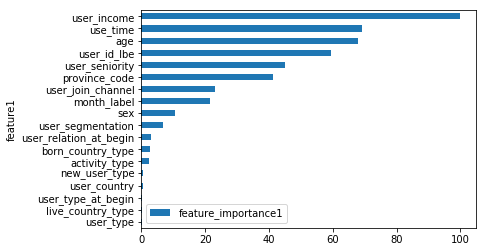

In [48]:
feature_importance_df1.plot(kind = 'barh')
